# Database source

#### [Kaggle Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)

# Import Modules

In [150]:
import random
import os 
import cv2
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import itertools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, Flatten, AveragePooling2D, Dropout
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [2]:
tf.__version__

'2.0.0'

In [3]:
#Training data directory
Train_Directory='Training'

In [4]:
os.listdir(Train_Directory)

['0', '1', '2', '3']

# Using image data generator to use tensor images

In [5]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [6]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory= Train_Directory, shuffle= True, target_size=(64,64), class_mode = 'categorical', subset="training")


Found 2297 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= Train_Directory, shuffle= True, target_size=(64,64), class_mode = 'categorical', subset="validation")


Found 573 images belonging to 4 classes.


In [8]:
# Number of total images are = 826 + 822 + 395 + 827 = 2870
# 20% Validation aprox. = 573
# remaining = 2297

# Example of a simple batch of images

In [9]:
train_images, train_labels = next(train_generator)

In [10]:
train_images.shape

(40, 64, 64, 3)

In [11]:
train_labels.shape

(40, 4)

In [12]:
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]],

In [13]:
# labels Translator 
label_names = {0 : 'Glioma Tumor', 1 : 'Meningioma Tumor' , 2: 'No Tumor', 3 : 'Pituitary Tumor'}

# Visualize the data

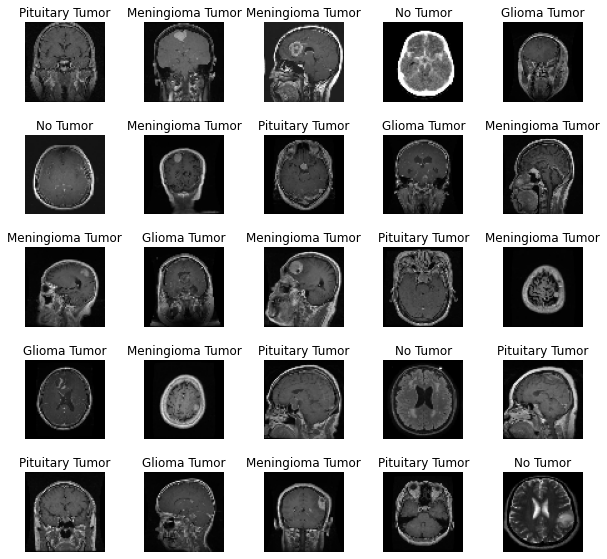

In [14]:
# Create a grid of 36 images along with their corresponding labels
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (10, 10))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5) 

# Use a pre-trained neural network to help on solving this classification problem
- For this work, ResNet (Residual Neural Network) will be adopted. ResNet is a powerfull trained network and it includes the skip connection feature which allows to overcome the problem of the vanishing gradient for networks with many layers. 
- It is going to be extracted the first layers to extract high level of general features. The last layers is going to be added by this problem to perform this specific task

In [15]:
model = ResNet50(include_top = False,
                weights = 'imagenet',
                input_tensor = Input(shape=(64,64,3))) # specify the shape for this problem

In [16]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
model.layers[:-10]

# Freezing the model on the last layers

In [18]:
for layer in model.layers[:-10]:
  layers.trainable = False

# Build the model

In [82]:
model2 = model.output
model2 = AveragePooling2D(pool_size = (2,2))(model2)
model2 = Flatten(name= 'flatten')(model2)
model2 = Dense(256, activation = "relu")(model2)
model2 = Dropout(0.3)(model2)
model2 = Dense(128, activation = "relu")(model2)
model2 = Dropout(0.2)(model2)
model2 = Dense(4, activation = 'softmax')(model2)

model_final = Model(inputs = model.input, outputs = model2)

In [83]:
model_final.compile(loss = 'categorical_crossentropy', 
               optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), 
               metrics= ["accuracy"])

In [84]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

#### Reduce the batch size for the training

In [85]:
train_generator = image_generator.flow_from_directory(batch_size = 2, directory= Train_Directory, shuffle= True, target_size=(64,64), class_mode = 'categorical', subset="training")
validation_generator = image_generator.flow_from_directory(batch_size = 2, directory= Train_Directory, shuffle= True, target_size=(64,64), class_mode = 'categorical', subset="validation")


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [86]:
history = model_final.fit_generator(train_generator, 
                              steps_per_epoch= train_generator.n // 40, 
                              epochs = 10, 
                              validation_data= validation_generator, 
                              validation_steps= validation_generator.n // 4, 
                              callbacks=[checkpointer, earlystopping])

Epoch 1/10
56/57 [============================>.] - ETA: 1s - loss: 0.6327 - accuracy: 0.7857
Epoch 00001: val_loss improved from inf to 0.76176, saving model to weights.hdf5
57/57 [==============================] - 87s 2s/step - loss: 0.6226 - accuracy: 0.7895 - val_loss: 0.7618 - val_accuracy: 0.8042
Epoch 2/10
56/57 [============================>.] - ETA: 1s - loss: 0.2725 - accuracy: 0.9286
Epoch 00002: val_loss improved from 0.76176 to 0.67886, saving model to weights.hdf5
57/57 [==============================] - 91s 2s/step - loss: 0.2728 - accuracy: 0.9298 - val_loss: 0.6789 - val_accuracy: 0.8392
Epoch 3/10
56/57 [============================>.] - ETA: 1s - loss: 0.1919 - accuracy: 0.9464
Epoch 00003: val_loss improved from 0.67886 to 0.67833, saving model to weights.hdf5
57/57 [==============================] - 89s 2s/step - loss: 0.1889 - accuracy: 0.9474 - val_loss: 0.6783 - val_accuracy: 0.8322
Epoch 4/10
56/57 [============================>.] - ETA: 1s - loss: 0.2216 - acc

# Evaluate trained model

In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

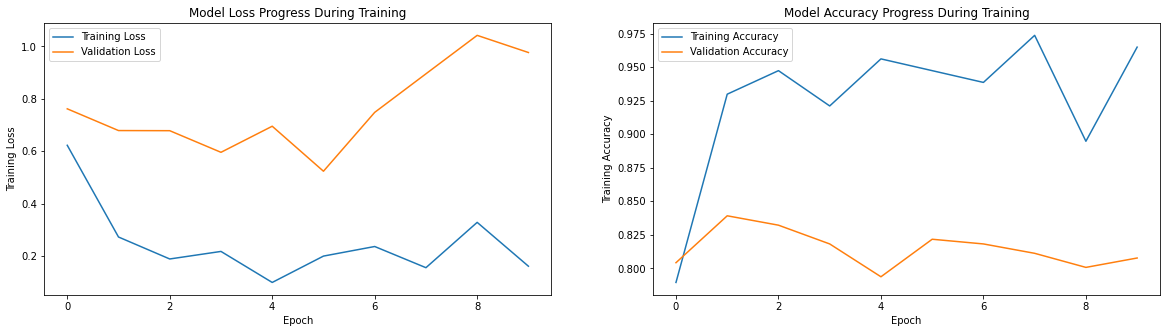

In [88]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss','Validation Loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

### Do the same thing as the training data (Image data gen to evaluate the test )

In [105]:
Test_Directory='Testing'

In [106]:
test_generator = ImageDataGenerator(rescale = 1./255)

In [107]:
test_generator = test_generator.flow_from_directory(batch_size = 4, directory= Test_Directory, shuffle= False, target_size=(64,64), class_mode= 'categorical')

Found 394 images belonging to 4 classes.


In [108]:
evaluate = model_final.evaluate_generator(test_generator, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1])) # 0 gives the loss and 1 the accuracy

99/99 [==============================] - 18s 186ms/step - loss: 3.9799 - accuracy: 0.6244 13s - loss: 10.46 - ETA: 11s - loss: 7. - ETA: 8s - los - ETA: 5s - loss: 4.1 - ETA: 4s - loss: 3.6324 - ac - ETA: 2s - l
Accuracy Test : 0.624365508556366


In [110]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(Test_Directory))):
  for item in os.listdir(os.path.join(Test_Directory,str(i))):
    img= cv2.imread(os.path.join(Test_Directory,str(i),item))
    img = cv2.resize(img,(64,64))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,64,64,3)
    predict = model_final.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [111]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.6091370558375635


In [132]:
import random
random.seed(0)

In [141]:
sample_idx = random.choice(range(len(image)))
sample_idx

350

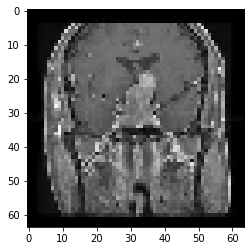

In [142]:
plt.imshow(image[sample_idx])

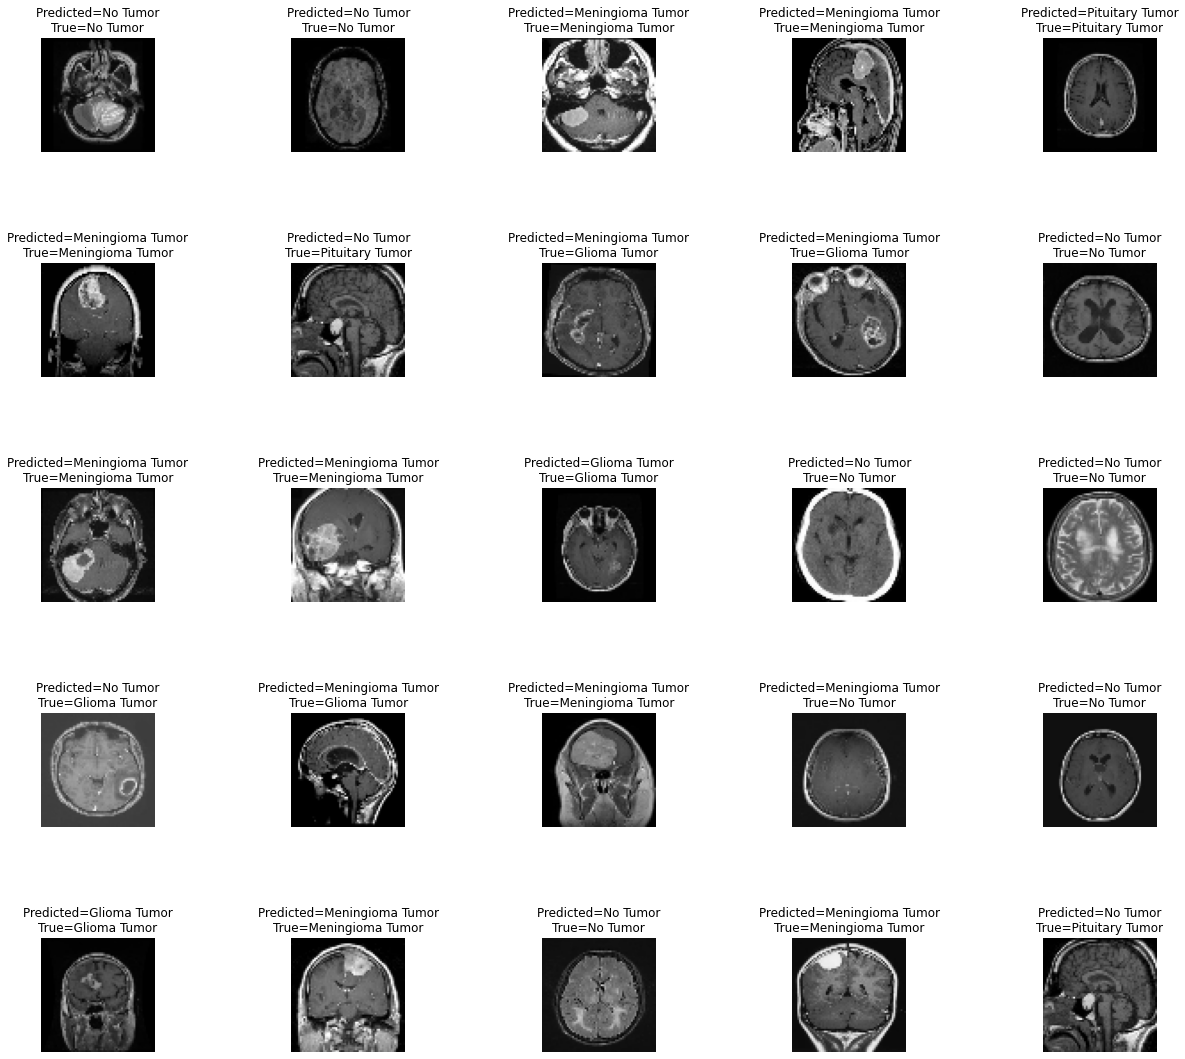

In [144]:

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (20, 20))
axes = axes.ravel()

for i in np.arange(0, L*W):
    sample_idx = random.choice(range(len(image)))
    axes[i].imshow(image[sample_idx])
    axes[i].set_title('Predicted={}\nTrue={}'.format(str(label_names[prediction[sample_idx]]), str(label_names[original[sample_idx]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [145]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.73      0.16      0.26       100
           1       0.49      1.00      0.66       115
           2       0.78      0.87      0.82       105
           3       0.86      0.24      0.38        74

    accuracy                           0.61       394
   macro avg       0.71      0.57      0.53       394
weighted avg       0.70      0.61      0.55       394



In [146]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
cm.shape

(4, 4)

In [147]:
LABEL_NAMES =['Glioma Tumor','Meningioma Tumor','No Tumor','Pituitary Tumor']

In [148]:
def plot_cm(cm, resolution, labels,NR_CLASSES=4):
    plt.figure(figsize=(10,10), dpi=resolution)
    plt.imshow(cm, cmap=plt.cm.Greens)
    plt.title("Confusion Matrix", fontsize=16)
    plt.ylabel("Actual Labels", fontsize=12)
    plt.xlabel("Predicted Labels", fontsize=12)

    tick_marks = np.arange(NR_CLASSES)
    plt.yticks(tick_marks, labels)
    plt.xticks(tick_marks, labels)

    plt.colorbar()

    for i, j in itertools.product(range(NR_CLASSES),range(NR_CLASSES)):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
            color='white' if cm[i,j]>80 else 'black')
    return plt.show()

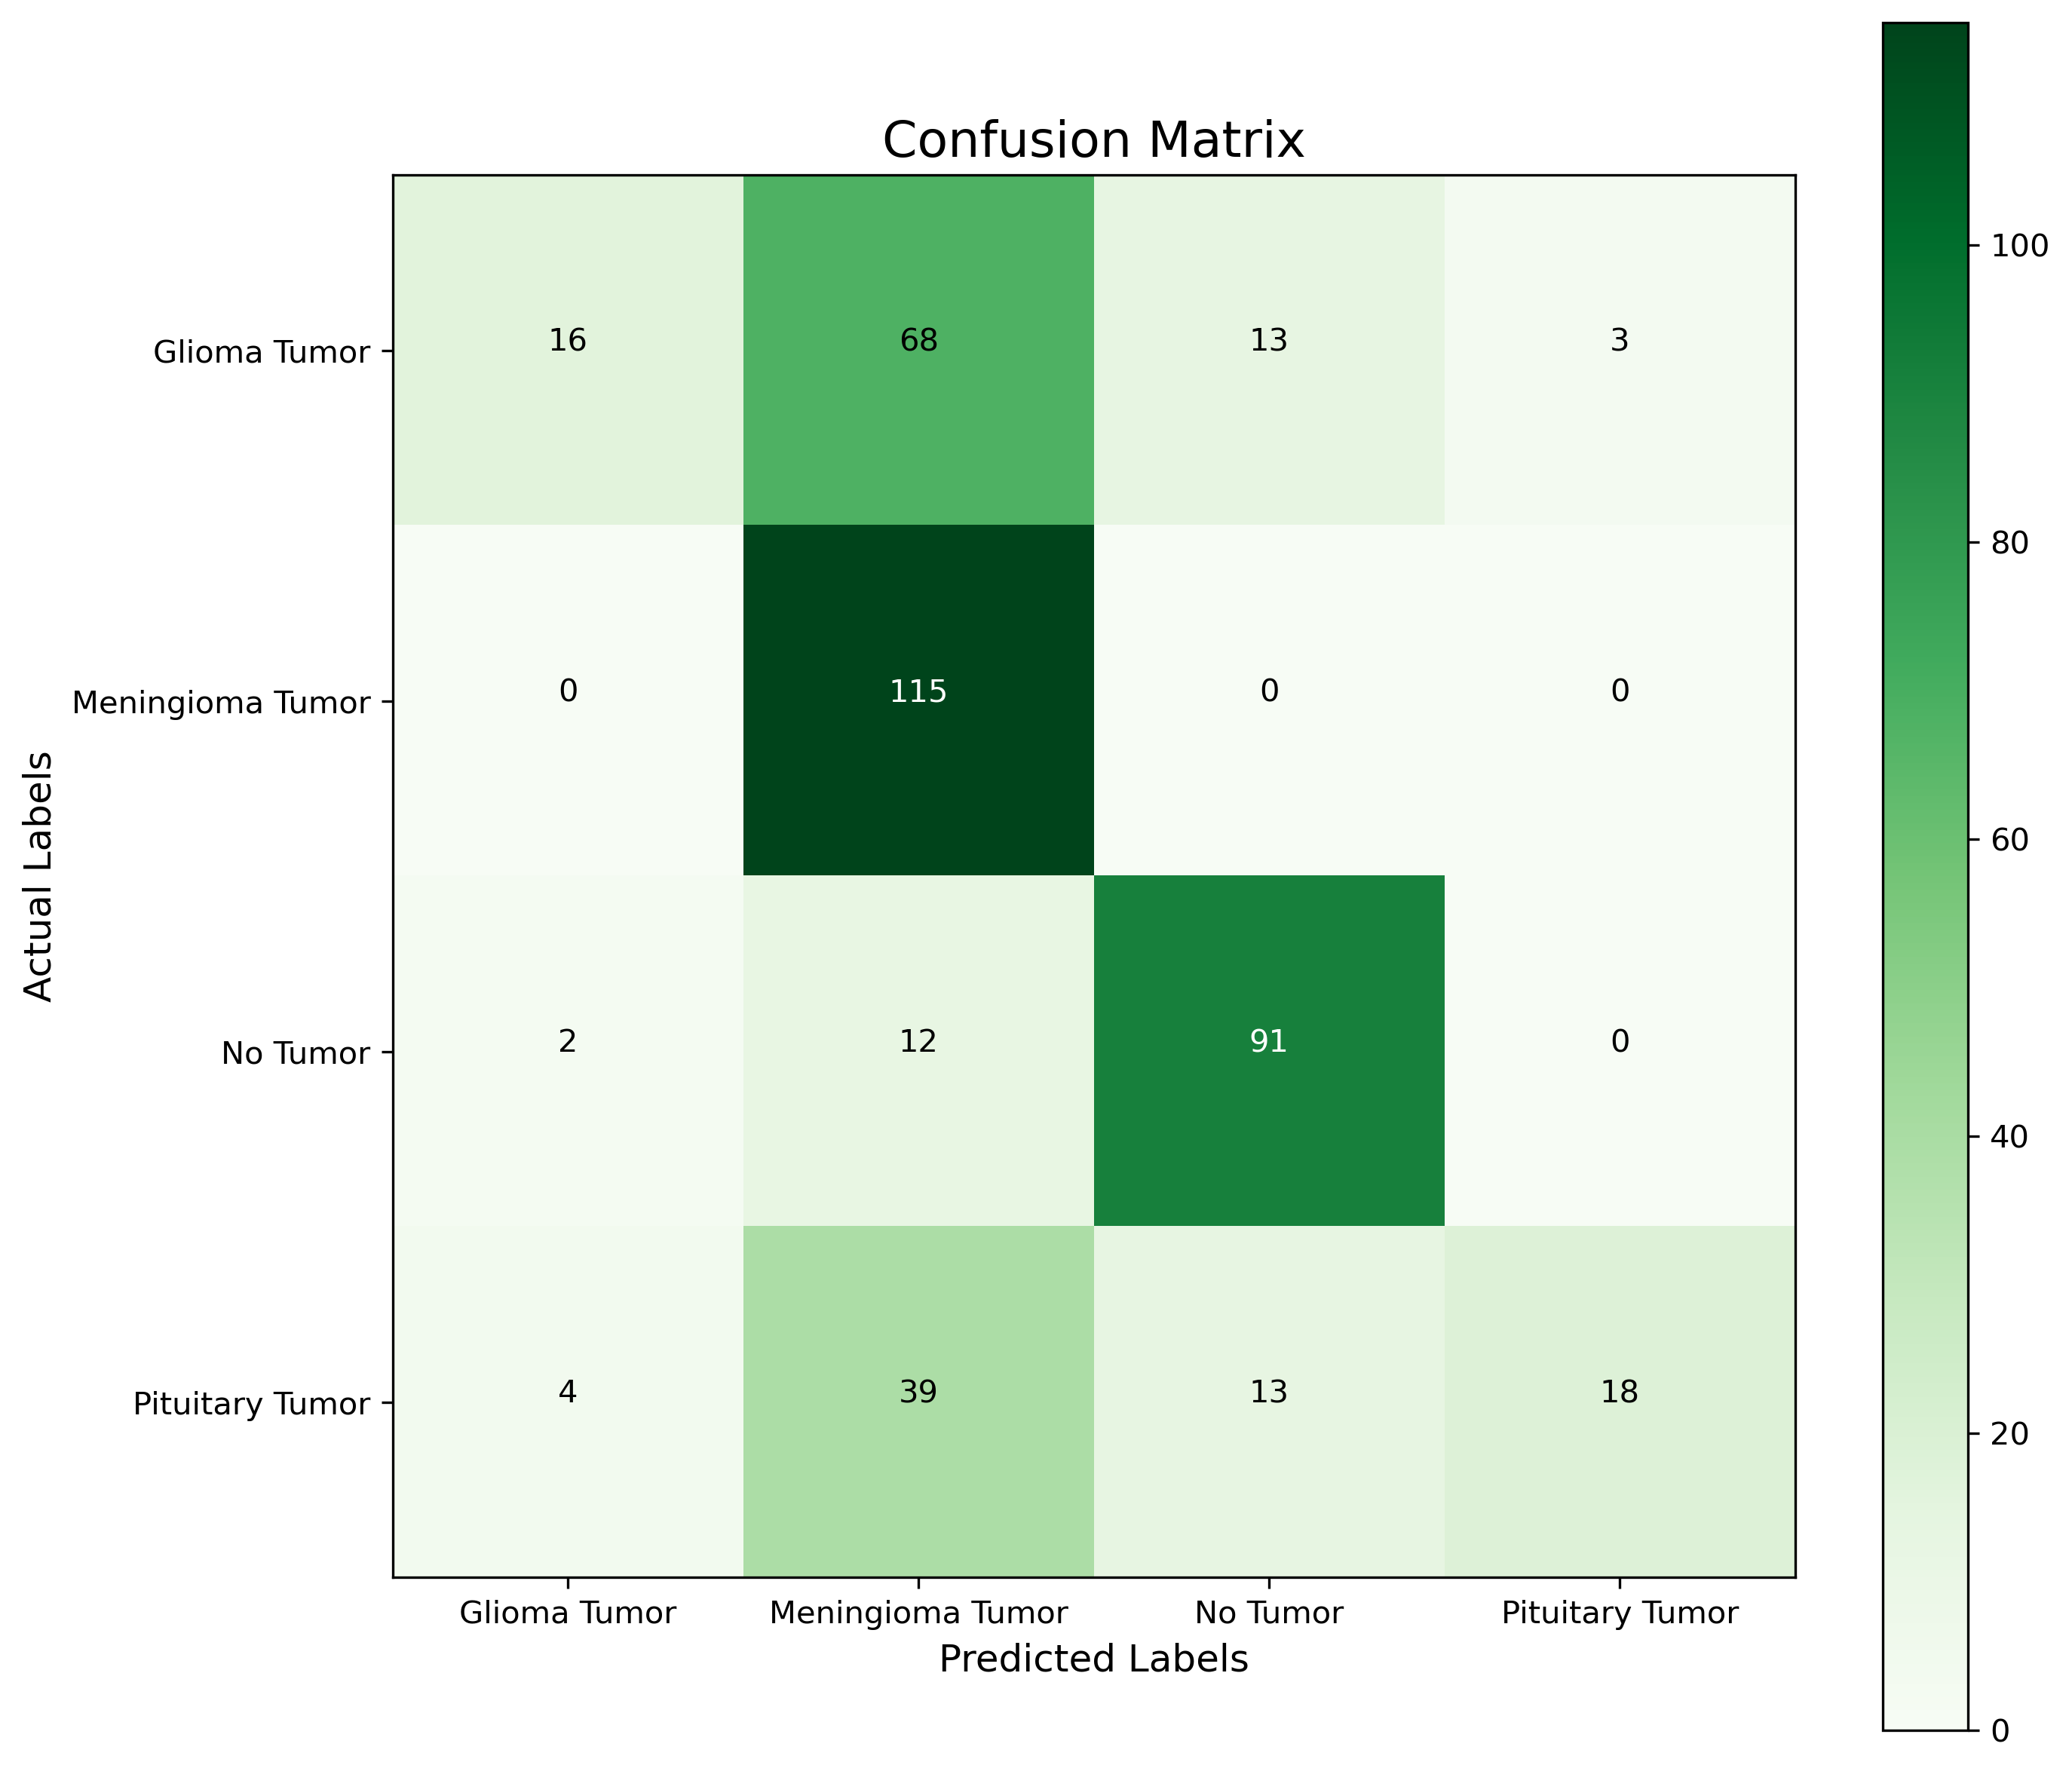

In [149]:
plot_cm(cm,resolution=300,labels=LABEL_NAMES)